# CDSDS 542 Deep Learning for Data Science - Discussion 11: Diffusion

![title](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png)


## 1. Diffussion Process

A diffusion process is a continuous time Markov stochastic process with continuous sample paths.
Any diffusion process can be described by a stochastic differential
equation (SDE)

$$dX_t = a(X_t,t)dt + \sigma(X_t,t)dW_t$$


### 1.1 Interpretation

* **Drift $a(\cdot)$**: tells you which direction the process moves *on average*.
* **Diffusion $\sigma(\cdot)$**: controls the randomness or noise level.
* **$W_t$** is Brownian motion, a continuous but highly irregular random path.

### 1.2 Discretizing the SDE

To simulate or train diffusion models, we need to **discretize** the continuous SDE.

#### 1.2.1 Wiener increments

A key property of Brownian motion:

$$dW_t = W_{t+dt} - W_t \sim {N}(0, dt)$$

That is, its increment over a small step $dt$ is normally distributed with variance $dt$.


#### 1.2.2 Discretizing the SDE

Starting from:

$$dX_t = a(X_t,t)dt + \sigma(X_t,t)dW_t,$$

we approximate:

$$X_{t+dt} - X_t \approx a(X_t,t)dt + \sigma(X_t,t) U$$
where $U \sim N(0,dt)$

#### 1.2.3 Equivalent form

Since $\sigma(X_t,t)U \sim N(0, \sigma(X_t,t)^2dt)$, we can write:

$$X_{t+dt} \approx X_t
+ a(X_t,t)dt + U'$$
where $U' \sim  N\big(0,\sigma(X_t,t)^2dt \big)$




## Exercise 1: simulate a diffusion process
Below we simulate several diffusion processes using:
$$ X_{t+dt} = X_t + a(X_t,t)dt + \sigma(X_t,t)\sqrt{dt}\cdot Z \quad Z\sim N(0,1)$$

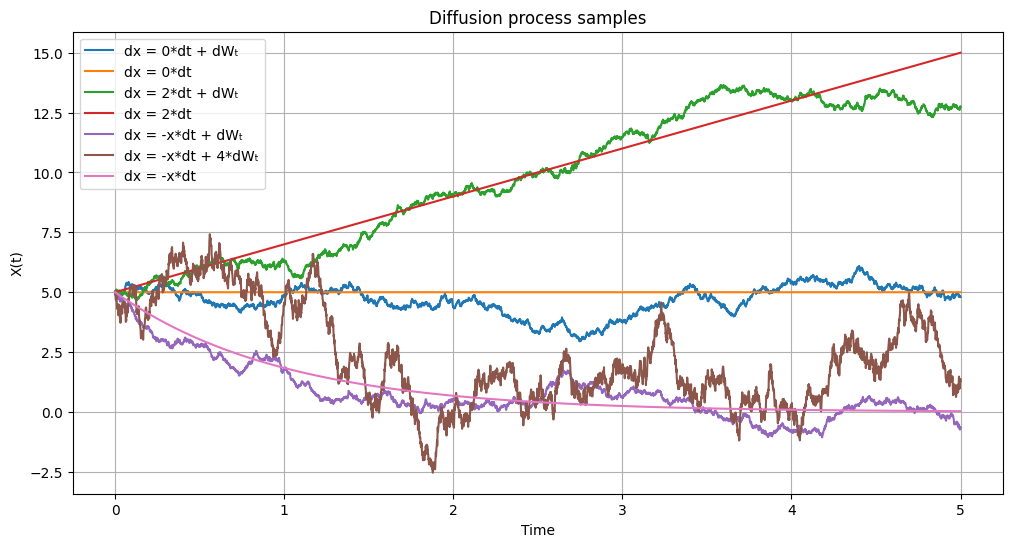

In [1]:
# TODO: follow the SDE to simulate a diffusion process

import numpy as np
import matplotlib.pyplot as plt

def simulate_sde(a, sigma, T=5.0, dt=0.001, x0=5.0):

    N = int(T / dt)
    X = np.zeros(N)
    X[0] = x0

    for i in range(1, N):
        t = i * dt
        dW = np.sqrt(dt) * np.random.randn()
        X[i] = X[i-1] + a(X[i-1], t) * dt + sigma(X[i-1], t) * dW
    return X

dt, T, x0 = 0.001, 5, 5
processes = [
    (lambda x,t: 0,   lambda x,t: 1, "dx = 0*dt + dWₜ"),
    (lambda x,t: 0,   lambda x,t: 0, "dx = 0*dt"),
    (lambda x,t: 2,   lambda x,t: 1, "dx = 2*dt + dWₜ"),
    (lambda x,t: 2,   lambda x,t: 0, "dx = 2*dt"),
    (lambda x,t: -x,  lambda x,t: 1, "dx = -x*dt + dWₜ"),
    (lambda x,t: -x,  lambda x,t: 4, "dx = -x*dt + 4*dWₜ"),
    (lambda x,t: -x,  lambda x,t: 0, "dx = -x*dt"),
]


results = [simulate_sde(a, sigma, T=T, dt=dt, x0=x0) for a, sigma, _ in processes]
plt.figure(figsize=(12,6))
t = np.linspace(0, T, len(results[0]))
for X, (_, _, label) in zip(results, processes):
    plt.plot(t, X, label=label)

plt.title("Diffusion process samples")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend()
plt.grid(True)
plt.show()

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


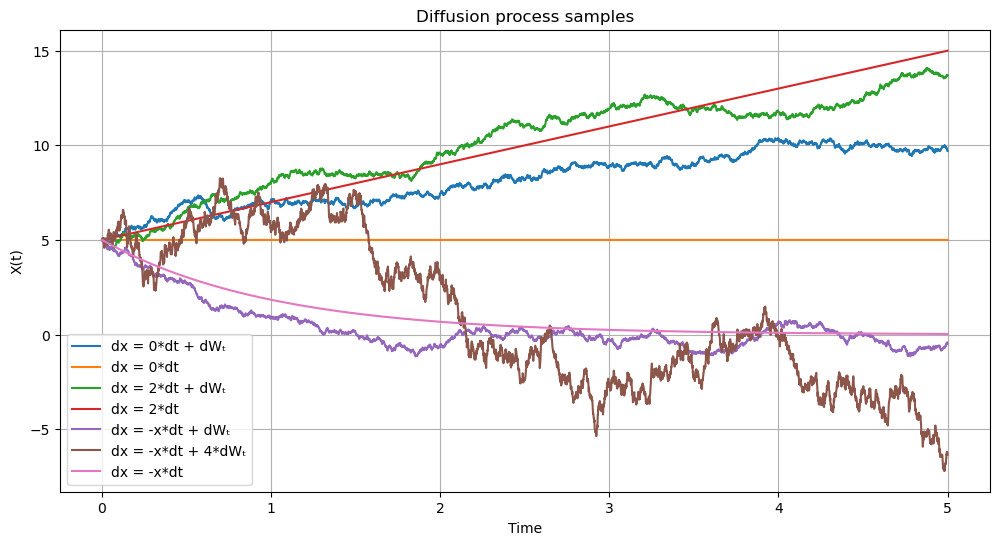

In [ ]:
# Expected output:

### 1.3 Reverse-Time Diffusion Process

Let $X_t$ be a diffusion process following:

$$dX_t = a(X_t,t)dt + \sigma(t) dW_t$$

Define a **time-reversed process**:

$$\bar X_t = X_{T-t}$$

Then $\bar X_t$ is also a diffusion process and satisfies the SDE:

$$d\bar X_t =
\Big[
a(\bar X_t,t)
-\sigma^2(t)\nabla_{X_t}\log p(X_t)
\Big] dt+\sigma(t) dW_t$$


#### 1.3.1 Score Function

$$\nabla_{X_t}\log p(X_t)$$

is called the **score function**, i.e., the gradient of the log-density of $X_t$.

* It tells you in which direction the data density increases.
* Diffusion models learn this score function.

#### 1.3.2 Why Reverse-Time Matters

Forward diffusion:
We gradually add Gaussian noise to data.

Reverse diffusion:
We simulate the **reverse SDE**, using the score function to iteratively *denoise* samples.

This gives rise to **DDPM**.



## 2. Process

### Diffusion process

* The basic idea behind diffusion models is rather simple. They take the input image x₀ and gradually add Gaussian noise to it through a series of T steps.
* This is unrelated to the model forward pass. The forward pass here is to create targets for the model to learn from.
* Afterward, a neural network is trained to recover the original data by reversing the noising process. By being able to model the reverse process, we can generate new data. This is the so-called reverse diffusion process or, in general, the sampling process of a generative model.

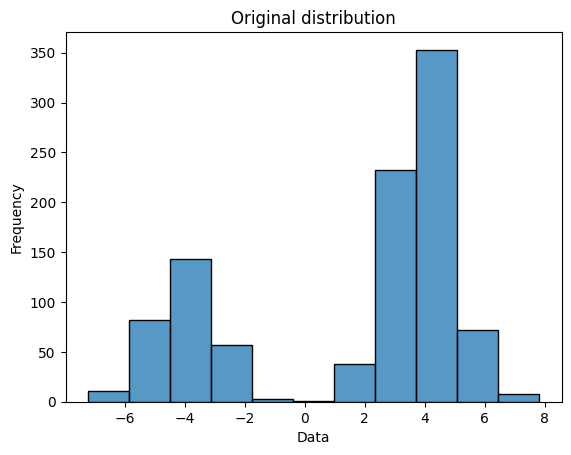

In [2]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bimodal distributed data (representing a "complex" data distribution)
data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([1, 2])),
    torch.distributions.Normal(torch.tensor([-4., 4.]), torch.tensor([1., 1.]))
)

# create 1000 samples
dataset = data_distribution.sample(torch.Size([1000, 1]))

# visualize - original data distribution
sns.histplot(dataset[:, 0])
plt.title("Original distribution")
plt.xlabel("Data")
plt.ylabel("Frequency")
plt.show()

#### 2.1 Forward Process

Now let's look at the first stage of diffusion: the **forward process**.
The forward process is very simple: given a real data point $x_0$, we gradually add Gaussian noise to it. After $T$ steps, the data becomes pure noise.

![title](https://theaisummer.com/static/1f5f940d6d3f1e00b3777066f6695331/073e9/forward-diffusion.png)

Mathematically, the transition at each step is:

$$q(x_t \mid x_{t-1}) = N(x_t; \mu_t = \sqrt{(1-\beta_t)} x_{t-1}, \Sigma_t = \beta_t I)$$

Each dimension has the same standard deviation βₜ

Here:

* $\beta_t$ is the noise strength $variance$ at step $t$
* We define $\alpha_t = 1 - \beta_t$
* This is a **Markov chain**: each step depends only on the previous one.


If we want to know the state at step 500, do we really have to compute 500 steps?

**No:** We can jump directly to any time step $t$ without simulating all previous steps:

$$ q(x_{1:T} \mid x_0) = \prod_{t=1}^T q(x_t \mid x_{t-1}) $$

**Code Implementation: Sampling from the Forward Process**

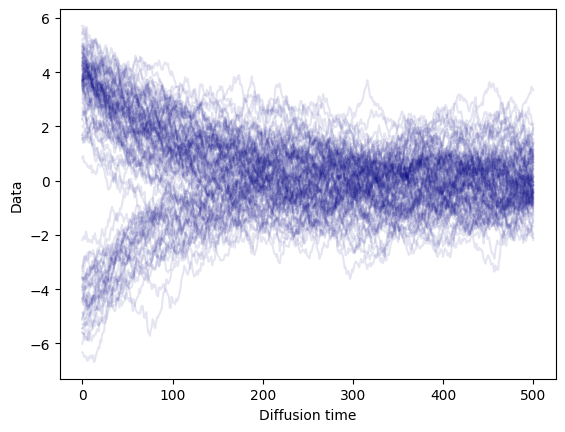

In [3]:
TIME_STEPS = 500
BETA = 0.02

def do_diffusion(data, steps=TIME_STEPS, beta=BETA):

    # perform diffusion following above equation
    # returns a list of q(x(t)) and x(t)
    # starting from t=0 (i.e., the dataset)

    distributions, samples = [None], [data]
    xt = data

    for t in range(steps):
        # In step t, starting from xt in the previous step, add Gaussian noise
        q = torch.distributions.Normal(
            np.sqrt(1 - beta) * xt,  # Mean: Reduce the data from the previous step
            np.sqrt(beta)             # Standard deviation: Noise intensity
        )
        xt = q.sample()  # Sampling yields the new xt

        distributions.append(q)
        samples.append(xt)

    return distributions, samples

# perform diffusion
_, samples = do_diffusion(dataset)

# Draw the diffusion process: Each line represents the "diffusion trajectory" of a data point.
for t in torch.stack(samples)[:, :, 0].T[:100]:
    plt.plot(t, c='navy', alpha=0.1)

plt.xlabel('Diffusion time')
plt.ylabel('Data')
plt.show()

We can see. All data points are gradually spread from the original two peaks (around $–4$ and $+4$) into the entire space, and eventually become random noise (around $0$).

**Jump Directly to Step $t$**

We just saw that to obtain a sample at step $t$, we normally need to iterate through all previous steps.
This is very inefficient during training.
The reparameterization trick allows us to jump directly from $x_0$ to $x_t$

Through mathematical derivation (properties of Gaussian distributions), we can show that:

$$x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t}\cdot \varepsilon$$

Where:

* $$
  \bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i \quad \text{(cumulative product)}
  $$

* $$
  \varepsilon \sim {N}(0, I) \quad \text{(standard Gaussian noise)}
  $$

This means:
$x_t$ is simply a weighted combination of the original data $x_0$ and noise.
When $t$ becomes large, $\bar{\alpha}_t \to 0$, so $x_t$ becomes pure noise.

**Visualization of the Derivation**

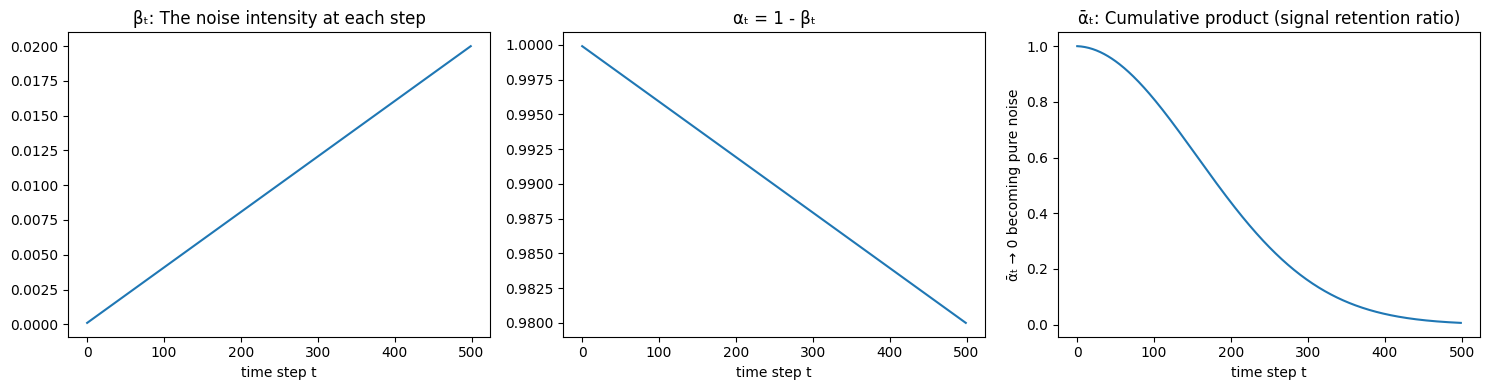

In [4]:
T = TIME_STEPS
beta = torch.linspace(0.0001, 0.02, T)  # Noise schedule: From small to large
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product

# Visual Noise schedule
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(beta.numpy())
axes[0].set_title('βₜ: The noise intensity at each step')
axes[0].set_xlabel('time step t')

axes[1].plot(alpha.numpy())
axes[1].set_title('αₜ = 1 - βₜ')
axes[1].set_xlabel('time step t')

axes[2].plot(alpha_bar.numpy())
axes[2].set_title('ᾱₜ: Cumulative product (signal retention ratio)')
axes[2].set_xlabel('time step t')
axes[2].set_ylabel('ᾱₜ → 0 becoming pure noise')

plt.tight_layout()
plt.show()

Notice the last figure: as time increases, $\bar{\alpha}_t$ gradually approaches 0.
This means that the original signal becomes almost completely drowned out by noise.

#### 2.3 The Reverse Diffusion Process — Learning to Remove Noise

**The Core Challenge of the Reverse Process**: Now we know how data becomes noisy. But what we actually want is the reverse process: generating data from noise.

Ideally, we want to know the distribution $q(x_{t-1} \mid x_t)$,
i.e., *“given a noisy sample $x_t$, what is the previous sample $x_{t-1}$?”*

**Problem:** This distribution is intractable, we cannot compute it directly because it depends on the unknown true data distribution.

**Solution:** Use a neural network to *approximate* this reverse process

So, define a learnable model:

$$p_\theta(x_{t-1} \mid x_t) = {N}\big(x_{t-1};\ \mu_\theta(x_t, t),\ \Sigma_\theta(x_t, t)\big)$$

Our neural network $\theta$ must learn to predict:

* The mean $\mu_\theta(x_t, t)$
* The variance $\Sigma_\theta(x_t, t)$

In [5]:
import torch.nn as nn

# Define two simple neural networks: one for predicting the mean and the other for predicting the variance
mean_model = nn.Sequential(
    nn.Linear(2, 4),   # input: [xₜ, t] （data + time step）
    nn.ReLU(),
    nn.Linear(4, 1)    # output: mean value
)

var_model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Softplus()      # ensure that the variance is positive
)

Both networks take the current noisy state $x_t$ and the timestep $t$ as inputs, and output the mean and variance of the denoised distribution.
Note: synchronizing the timestep is crucial, because the amount of noise differs at each $t$.

#### 2.4 Training Objective

Using the theory of variational inference (ELBO — Evidence Lower Bound), we can derive:

**Goal:**

Maximize the lower bound of the log-likelihood:

$$\log p(x) \ge L_0 - L_T - \sum_{t=2}^{T} L_{t-1}$$

Where:

* **$L_0$: Reconstruction term** — ensures the final output matches real data
* **$L_T$: Prior matching term** — ensures the final noisy state is standard Gaussian
* **$L_{t-1}$: Denoising matching term** — teaches the model to reverse one noise step

After mathematical simplification, we obtain a much simpler training objective:

$$
L_{\text{simple}} =
\mathbb{E}\big[|\varepsilon - \varepsilon_\theta(\sqrt{\bar{\alpha}_t} \cdot x_0+
\sqrt{1 - \bar{\alpha}_t}⋅\varepsilon, t)|^2\big]
$$

The model needs to learn to predict the noise we added.

In [6]:
def compute_loss(forward_distributions, forward_samples, mean_model, var_model):  # compute elbo loss

    # Lₜ: prior matching term — xₜ should be close to standard Gaussian
    p = torch.distributions.Normal(
        torch.zeros(forward_samples[0].shape),
        torch.ones(forward_samples[0].shape)
    )
    loss = -p.log_prob(forward_samples[-1]).mean()

    # Σ Lₜ₋₁: denoising matching term
    for t in range(1, len(forward_samples)):
        xt = forward_samples[t]         # current noisy state
        xprev = forward_samples[t - 1]  # previous true state
        q = forward_distributions[t]    # forward distribution q(xₜ | xₜ₋₁)

        # prepare model input: [xₜ, normalized t]
        xin = torch.cat(
            (xt, (t / len(forward_samples)) * torch.ones(xt.shape[0], 1)),
            dim=1
        )

        # model-predicted reverse distribution pθ(xₜ₋₁ | xₜ)
        mu = mean_model(xin)
        sigma = var_model(xin)
        p = torch.distributions.Normal(mu, sigma)

        # compute KL divergence (via log probabilities)
        loss -= torch.mean(p.log_prob(xprev))  # encourage pθ to assign high prob to xₜ₋₁
        loss += torch.mean(q.log_prob(xt))     # regularization term

    return loss / len(forward_samples)

What does this loss function do?
1. The first term ensures that the final state (x_T) is standard Gaussian.
2. The denoising terms ensure that at every step of the reverse process, the model can accurately recover the previous state.

#### 2.5 Full Training Loop
Now we have all components:

1. **Forward process:** add noise
2. **Reverse model:** the neural network
3. **Loss function:** ELBO

The training loop is very simple:

1. Sample a real datapoint $x_0$.
2. Run the forward process to obtain a noisy sample $x_t$.
3. Let the model learn the reverse process.
4. Compute the loss and update the parameters.

Let's train for 1000 epochs:

  0%|          | 0/1000 [00:00<?, ?it/s]

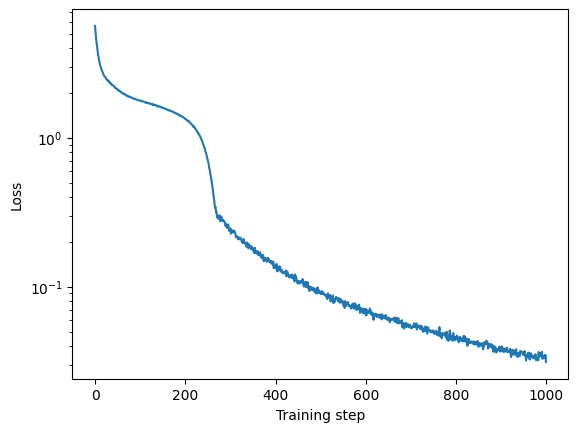

In [7]:
from tqdm.auto import tqdm
import itertools

# optimizer
optim = torch.optim.AdamW(
    itertools.chain(mean_model.parameters(), var_model.parameters()),
    lr=1e-2,
    weight_decay=1e-6
)

# train loop
loss_history = []
bar = tqdm(range(1000))

for epoch in bar:
    # 1. forward diffusion
    forward_distributions, forward_samples = do_diffusion(dataset)

    # 2. compute loss
    optim.zero_grad()
    loss = compute_loss(forward_distributions, forward_samples,
                       mean_model, var_model)

    # 3. Backpropagation
    loss.backward()
    optim.step()

    # record
    bar.set_description(f'Loss: {loss.item():.4f}')
    loss_history.append(loss.item())

# visualization
plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.show()

Notice the loss curve: it starts very high (the model does not yet know how to denoise), then drops quickly, and finally converges.
This indicates that the model has learned the reverse diffusion process!


#### 2.6 Sampling — Generating New Data From Noise

Once training is complete, we can generate new data.

**Sampling Algorithm:**

1. **Sample** the initial noise
   
   $$x_T \sim {N}(0, I)$$

2. **Iteratively denoise** from $t = T$ down to $t = 1$:

$$x_{t-1} = \mu_\theta(x_t, t) + \sigma_\theta(x_t, t)\cdot z$$
$$(\text{where } z \sim {N}(0, I), \text{ except for the final step})$$

3. **Return** $x_0$

This is like a painter who starts with a blank, noisy canvas and gradually carves out a clear picture

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*DUDhU2fwJNjlGOshW5yn_A.png)

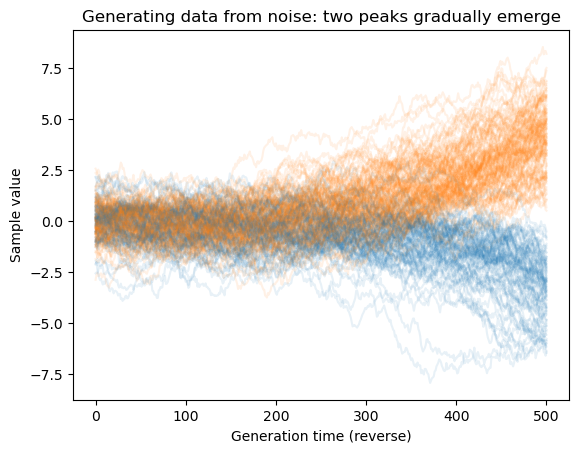

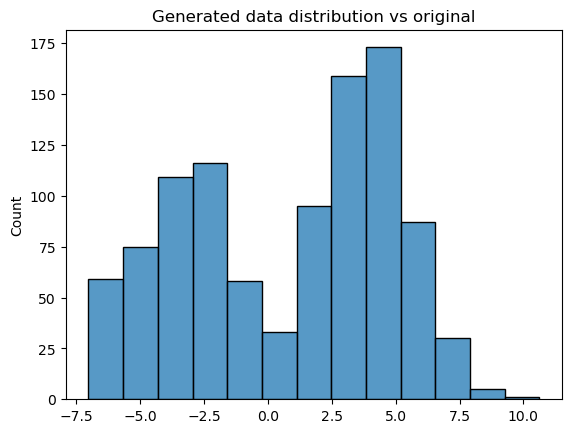

In [ ]:
# You don't have to run this cell because it costs 10 mins

# Generate new data by reversing the diffusion process.
def sample_reverse(mean_model, var_model, count, steps=TIME_STEPS):

    # 1. Start from a standard Gaussian
    p = torch.distributions.Normal(
        torch.zeros(count, 1),
        torch.ones(count, 1)
    )
    xt = p.sample()
    sample_history = [xt]

    # 2. Gradually denoise step by step
    for t in range(steps, 0, -1):
        # Prepare input
        xin = torch.cat((xt, t * torch.ones(xt.shape) / steps), dim=1)

        # Model prediction of the reverse distribution
        p = torch.distributions.Normal(
            mean_model(xin),
            var_model(xin)
        )

        # Sample the next step (stochastic, except near the end)
        xt = p.sample()
        sample_history.append(xt)

    return sample_history

# Generate 1000 new samples
samps = torch.stack(sample_reverse(mean_model, var_model, 1000))

# Visualize the generation process
for t in samps[:, :, 0].T[:200]:
    plt.plot(t, c=f'C{int(t[-1] > 0)}', alpha=0.1)
plt.xlabel('Generation time (reverse)')
plt.ylabel('Sample value')
plt.title('Generating data from noise: two peaks gradually emerge')
plt.show()

# Final generated data distribution
sns.histplot(samps[-1, :, 0])
plt.title('Generated data distribution vs original')
plt.show()


* **First figure:** The data starts as random noise (near 0) and gradually separates into two peaks.
* **Second figure:** The final generated distribution looks very similar to the original data distribution.


### 3. Extending to Images — MNIST Digit Generation

#### 3.1 From 1D to 2D Images

We just verified the diffusion model on 1D data.
Now let's work with real images!

For images, the only differences are:

* The data changes from **1D vectors** to **2D images** (28×28 pixels)
* We need a **more powerful network** to model complex image structures
* We use a **U-Net architecture**

* Unet’s architecture allows it to capture and utilize feature information at multiple scales, which is essential in accurately predicting the noise terms in the diffusion process.

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*vbYC9E8-hi_76lB4d1BvYg.png)
**U-Net characteristics:**

* Encoder–decoder structure
* Skip connections
* Capable of capturing multi-scale features

Additionally, we introduce **conditional generation**:
We tell the model which digit (0–9) to generate!

Load the MNIST dataset

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.83MB/s]

shape: torch.Size([128, 1, 28, 28])
label: tensor([4, 3, 5, 3, 4, 1, 3, 5, 2, 3, 6, 8, 0, 3, 4, 0, 1, 3, 7, 5, 0, 3, 3, 7,
        9, 7, 5, 0, 0, 8, 6, 0, 4, 1, 2, 6, 9, 6, 3, 9, 0, 3, 1, 8, 0, 1, 9, 6,
        4, 5, 1, 4, 7, 2, 7, 1, 5, 6, 5, 3, 3, 0, 3, 9, 2, 7, 4, 8, 3, 6, 3, 9,
        2, 6, 4, 1, 8, 1, 9, 2, 4, 6, 2, 0, 8, 8, 3, 8, 3, 1, 7, 3, 2, 1, 3, 2,
        9, 2, 9, 5, 4, 5, 6, 4, 9, 2, 6, 3, 4, 8, 5, 2, 7, 8, 1, 7, 4, 0, 8, 8,
        7, 0, 2, 3, 7, 0, 2, 0])


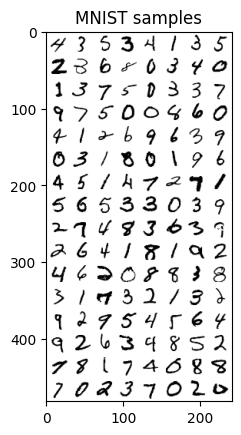

In [8]:
import torchvision
from torch.utils.data import DataLoader

# load MNIST dataset
dataset = torchvision.datasets.MNIST(
    root="mnist/",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# data example
x, y = next(iter(train_dataloader))
print('shape:', x.shape)  # [batch, channels, height, width]
print('label:', y)

plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
plt.title('MNIST samples')
plt.show()

#### 3.2: Conditional Generation — Class-Conditioned U-Net

To enable the model to generate a *specific* digit, we need **conditional generation**.

**Steps:**

1. **Use an Embedding layer** to map the label into a vector
2. **Expand this vector** to match the spatial dimensions of the image
3. **Concatenate** it with the noisy image as input to the U-Net

This way, the network *knows* which digit the user wants to generate.

**Implementation of the Conditional U-Net**

In [9]:
from diffusers import UNet2DModel
from tqdm.auto import tqdm
import itertools

class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()

        # Embedding layer: maps class labels (0–9) into a 4-dimensional vector
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # U-Net: input channels = 1 (grayscale image) + 4 (class embedding) = 5
        self.model = UNet2DModel(
            sample_size=28,
            in_channels=1 + class_emb_size,  # image + conditioning
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",   # with attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
            ),
        )

    def forward(self, x, t, class_labels):
        # x: [batch, 1, 28, 28]       input image
        # t: [batch]                  timestep conditioning
        # class_labels: [batch]       class index (0–9)

        bs, ch, w, h = x.shape

        # 1. Class embedding
        class_cond = self.class_emb(class_labels)  # [batch, 4]

        # 2. Expand embedding to spatial dimensions
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1)
        class_cond = class_cond.expand(bs, class_cond.shape[1], w, h)
        # Now class_cond is [batch, 4, 28, 28]

        # 3. Concatenate image and class condition: [batch, 1+4, 28, 28]
        net_input = torch.cat((x, class_cond), dim=1)

        # 4. U-Net predicts the noise
        return self.model(net_input, t).sample

* The class information is *broadcast* to every pixel location
* The U-Net can “see” the target digit class while processing the image

#### 3.4 MNIST Training Loop

## Exercise 2: Complete a image trainning

In [10]:
!pip install diffusers -q

In [11]:
# TODO: complete the following trainning process, please use a GPU resource.

from diffusers import DDPMScheduler
device = 'cuda'

# Create noise scheduler (automatically handles βₜ and ᾱₜ)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Create model
net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Train for 5 epochs
n_epochs = 5
losses = []

for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        x = x.to(device) * 2 - 1  # normalize to [-1, 1]
        y = y.to(device)

        # 1. Add noise (forward diffusion process)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # 2. Model predicts noise
        pred_noise = net(noisy_x, timesteps, y)  # Note: pass label y

        # 3. Simplified loss: predicted noise vs. true noise
        loss = loss_fn(pred_noise, noise)

        # 4. Update parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:]) / 100
    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0, Loss: 0.0329


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Loss: 0.0283


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0262


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0251


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0239


In [ ]:
# Expected output:

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0, Loss: 0.0335


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Loss: 0.0286


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0267


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0258


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0246


Note that here we are using a simplified loss function: directly having the model predict the added noise. This is simpler than the previous ELBO, but it works just as well.

**Generate samples for a specified digit.**

processing digit 0
processing digit 1
processing digit 2
processing digit 3
processing digit 4
processing digit 5
processing digit 6
processing digit 7
processing digit 8
processing digit 9


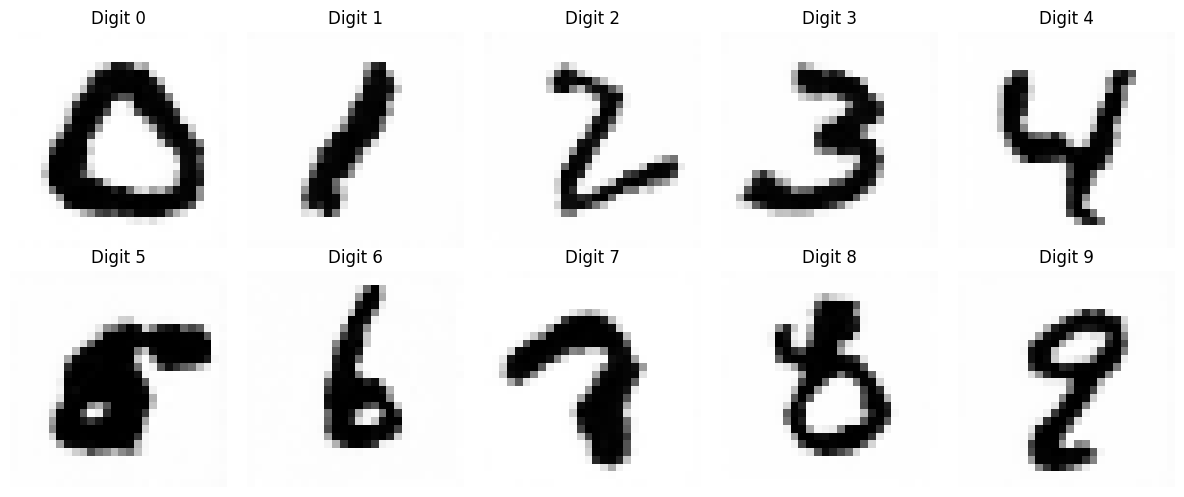

In [12]:
# TODO: Generate samples for a specified digit
def generate_digits(net, noise_scheduler, digit, num_samples=10):
    # 1. Start from pure noise
    x = torch.randn(num_samples, 1, 28, 28).to(device)

    # 2. Class labels: all set to the desired digit
    y = torch.tensor([digit] * num_samples).to(device)

    # 3. Gradually denoise through reverse diffusion
    for i, t in enumerate(noise_scheduler.timesteps):
        with torch.no_grad():
            # Predict noise
            residual = net(x, t, y)

            # Take one reverse step (scheduler handles mathematics internally)
            x = noise_scheduler.step(residual, t, x).prev_sample

    return x

# Generate one sample for each digit 0–9
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for digit in range(10):
    print(f'processing digit {digit}')
    samples = generate_digits(net, noise_scheduler, digit, num_samples=1)
    ax = axes[digit // 5, digit % 5]
    ax.imshow(samples[0, 0].cpu(), cmap='Greys')
    ax.set_title(f'Digit {digit}')
    ax.axis('off')

plt.tight_layout()
plt.show()

processing digit 0
processing digit 1
processing digit 2
processing digit 3
processing digit 4
processing digit 5
processing digit 6
processing digit 7
processing digit 8
processing digit 9


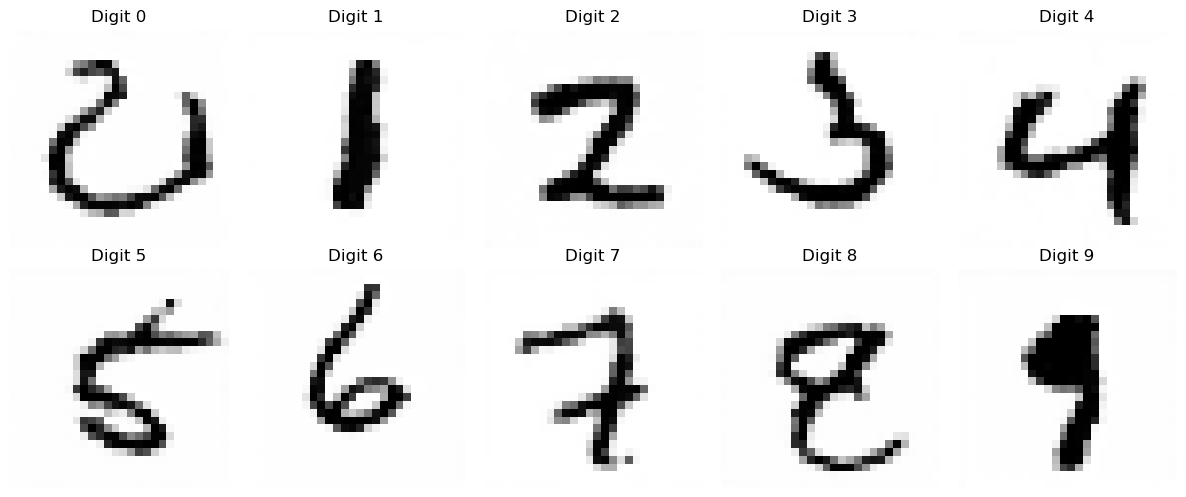

In [ ]:
# Expected output: